# Introduction

This uses the integrator in MSMBuilder to simulate data from a potential. 


## Imports and defaults

In [1]:
from msmbuilder.cluster import NDGrid
from pyemma.msm import BayesianMSM, MaximumLikelihoodMSM

/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/robert_arbon/anaconda/envs/sonification/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version.

In [2]:
import pyemma.msm as msm
import pyemma.plots as mplt


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy
import pandas as pd
from numpy import random
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [4]:
sns.set_style('ticks')
sns.set_context('paper')

## Transition matrix and potential

In [5]:
def _normalize_eigensystem(u, lv, rv):
    """Normalize the eigenvectors of a reversible Markov state model according
    to our preferred scheme.
    """
    # first normalize the stationary distribution separately
    pi = lv[:, 0]
    lv[:, 0] = lv[:, 0] / np.sum(lv[:, 0])
    
    for i in range(1, lv.shape[1]):
        # the remaining left eigenvectors to satisfy
        # <\phi_i, \phi_i>_{\mu^{-1}} = 1
        lv[:, i] = lv[:, i] / np.sqrt(np.dot(lv[:, i], lv[:, i] / lv[:, 0]))

    for i in range(rv.shape[1]):
        # the right eigenvectors to satisfy <\phi_i, \psi_j> = \delta_{ij}
        rv[:, i] = rv[:, i] / np.dot(lv[:, i], rv[:, i])

    return u, lv, rv, pi

def _solve_msm_eigensystem(transmat, k):
    u, lv, rv = scipy.linalg.eig(transmat, left=True, right=True)
    order = np.argsort(-np.real(u))
    u = np.real_if_close(u[order[:k]])
    lv = np.real_if_close(lv[:, order[:k]])
    rv = np.real_if_close(rv[:, order[:k]])
    return _normalize_eigensystem(u, lv, rv)

In [6]:
DIFFUSION_CONST = 1e3
DT = 1e-3
DT_SQRT_2D = DT * np.sqrt(2 * DIFFUSION_CONST)
ONE_OVER_SQRT_2PI = 1.0 / (np.sqrt(2 * np.pi))




In [7]:
def _reflect_boundary_conditions(x, min, max):
    if x > max:
        return 2 * max - x
    if x < min:
        return 2 * min - x
    return x

def brownian_transmat(n_grid, lag_time, xmin, xmax, A, B, C, reflect_bc):
    
    normalpdf = lambda x: ONE_OVER_SQRT_2PI * np.exp(-0.5 * (x * x))
    
    grid = np.linspace(xmin, xmax, n_grid)
    width = grid[1] - grid[0]
    transmat = np.zeros((n_grid, n_grid))
    
    for i, x_i in enumerate(grid):
        if reflect_bc:
            for offset in range(-(n_grid - 1), n_grid):
                x_j = x_i + (offset * width)
                j = _reflect_boundary_conditions(i + offset, 0, n_grid - 1)

                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i, A, B, C)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)
        else:
            for j, x_j in enumerate(grid):
                # What is the probability of going from x_i to x_j in one step?
                diff = (x_j - x_i + DT * grad_potential(x_i, A, B, C)) / DT_SQRT_2D
                transmat[i, j] += normalpdf(diff)

        transmat[i, :] = transmat[i, :] / np.sum(transmat[i, :])
    transmat = np.linalg.matrix_power(transmat, lag_time)
    return transmat

def potential(x, A, B, C):
    return 4 * (x ** 8 + C*0.8 * np.exp(-80 * (x ** 2)) + B*0.2 * np.exp(
        -80 * (x - 0.5) ** 2) +
                A*0.5 * np.exp(-40 * (x + 0.5) ** 2)) 

def grad_potential(x,  A, B, C):
    return 4 * (8 * x ** 7 - C*128 * x * np.exp(-80 * x ** 2) - \
    B*32 * (x - 0.5) * np.exp(-80 * (x - 0.5) ** 2) - A*40 * (x + 0.5) * np.exp(
        -40 * (x + 0.5) ** 2)) 

In [8]:
def _simulate_quadwell(n_steps=1e3, n_trajectories=100, x0=None, A=1, B=1, C=1):
    # DO NOT CHANGE THESE CONSTANTS WITHOUT UPDATING THE
    # "QUADWELL_DESCRIPTION" VARIABLE AND UPDATING THE VERSION NUMBER
    # in the load_quadwell FUNCTION
    if x0 is None:
        x0 = random.uniform(-1, 1, size=n_trajectories)

    trajectories = [_propagate1d(
        x0[i], n_steps, grad_potential,A, B, C, 
        random=random, verbose=False).reshape(-1, 1)
                    for i in range(n_trajectories)]
    return trajectories

In [9]:
def _propagate1d(x0, n_steps, grad_potential, A, B, C, random, bc_min=None, bc_max=None,
                 verbose=True):
    if verbose:
        print('potential parameters:', A, B, C)
    start = time.time()
    n_steps = int(n_steps)
    if bc_min is None and bc_max is None:
        bc = lambda x: x
    else:
        bc = lambda x: _reflect_boundary_conditions(x, bc_min, bc_max)

    rand = random.randn(n_steps)
    x = np.zeros(n_steps + 1)
    x[0] = x0
    for i in range(n_steps):
        x_i_plus_1 = x[i] - DT * grad_potential(x[i], A, B, C) + DT_SQRT_2D * rand[i]
        x[i + 1] = bc(x_i_plus_1)

    if verbose:
        print('%d steps/s' % (n_steps / (time.time() - start)))
    return x

# Simulation

In [10]:
# These are determined from QuadWell Exact Values
A = 1
B = 1
C = 1
tau = 20
xmin, xmax = -1.2, 1.2
N = 200
name='four-well-long'

In [11]:
T = brownian_transmat(N, tau, xmin, xmax, A, B, C, False)
u, lv, rv, pi =  _solve_msm_eigensystem(T, N)

##  Get starting points from equilibrium distribution

In [12]:
mu = np.real(pi)
mu_cum = np.cumsum(mu)
grid = np.linspace(xmin, xmax, N)
n_trajectories = int(1e2)
t2 = -tau/np.log(u[1])

In [20]:
ts = -tau/np.log(u[1:10])
np.save('timescales.npy', ts)

In [13]:
x0 = [np.searchsorted(mu_cum, i) for i in np.random.random(n_trajectories)]
x0 = [grid[i] for i in x0]

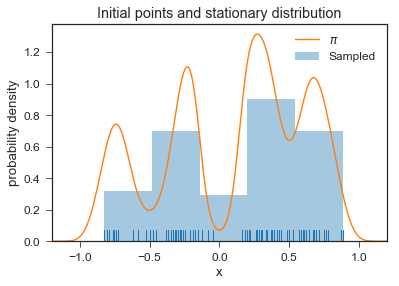

In [14]:
with sns.plotting_context('paper', font_scale=1.5):
    sns.distplot(x0, norm_hist=True, label='Sampled', kde=False, rug=True)
    plt.plot(grid, mu*100, label=r'$\pi$')
    plt.legend()
    plt.ylabel('probability density')
    plt.xlabel('x')
    plt.title('Initial points and stationary distribution')
    plt.xlim(xmin, xmax)
    


## Get trajectories

In [18]:
n_steps = int(2*t2)
T = n_steps*n_trajectories
print('Total length:     ', T, '/steps')
print('Traj length:      ', n_steps, '/steps')
print('Num trajectories: ', n_trajectories)
trajectories = _simulate_quadwell(n_steps=n_steps, n_trajectories=n_trajectories, x0=x0, A=A, B=B, C=C)


Total length:      168800 /steps
Traj length:       1688 /steps
Num trajectories:  100


In [19]:
_ = [np.save('data/'+name+'/{:02d}.npy'.format(i), traj) for i, traj in enumerate(trajectories)]

## Check convergence

In [23]:
cols = sns.color_palette('colorblind')

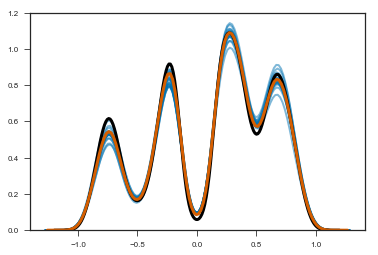

In [24]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=20, test_size=0.5)
for idx, jdx in cv.split(trajectories):
    test = np.concatenate([trajectories[i] for i in idx])
    sns.distplot(test, hist=False, color=cols[0], kde_kws={'lw':2, 'alpha':0.5})

# normalize mu. 
dx = grid[1]-grid[0]
scale = 0.5*dx*(mu[0] + mu[-1]) + dx*np.sum(mu[1:-1])

plt.plot(grid, mu/scale, label=r'$\pi$', color='k', lw=3)
sns.distplot(np.concatenate(trajectories), hist=False, color=cols[2], kde_kws={'lw':3, 'alpha':1})

## Test decorrelation time

In [96]:
def acf(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    x = x[:,0]
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    assert np.allclose(r, np.array([(x[:n-k]*x[-(n-k):]).sum() for k in range(n)]))
    result = r/(variance*(np.arange(n, 0, -1)))
    return result



In [97]:
C_rrs = [acf(traj[:5000]) for traj in trajectories]

In [98]:
C_rrs = [C_rr[:, np.newaxis] for C_rr in C_rrs]
C_rr = np.concatenate(C_rrs, axis=1)
C_rr = np.mean(C_rr, axis=1)

(-1, 1)

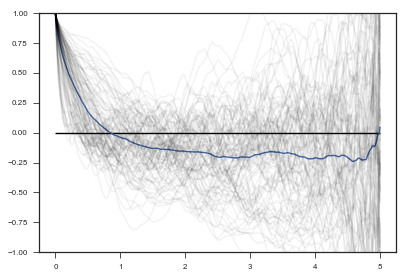

In [150]:
idx = np.arange(C_rr.shape[0])*DT
k = -1
plt.plot(idx[:k], C_rr[:k])
plt.hlines(0, idx[k], 0)
for y in C_rrs:
    plt.plot(idx[:k], y[:k], c='k', alpha=0.05)
plt.ylim((-1,1))

## Check implied timescales vs lag

In [194]:
steps_per_traj = trajectories[0].shape[0]
frac_traj = 5e-3
stride = 1
n_steps = int(frac_traj*steps_per_traj)
trajs = [traj[:n_steps:stride] for traj in trajectories]
print('Number of steps per trajectory {}'.format(n_steps))
print('Number of frames per trajectory {}'.format(int(n_steps/stride)))
print('Total length of trajectories {}/t2'.format(frac_traj*T/t2))

Number of steps per trajectory 422
Number of frames per trajectory 422
Total length of trajectories 0.05/t2


In [195]:
np.sqrt(422*100)

205.42638584174136

In [196]:
cluster = NDGrid(n_bins_per_feature=200, min=xmin, max=xmax)

In [197]:
ctrajs = cluster.fit_transform(trajs)

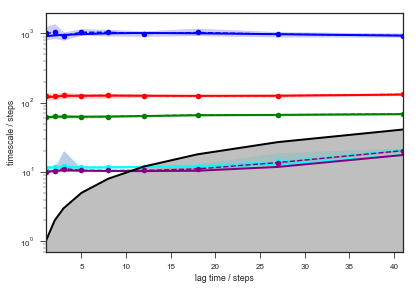

In [201]:
its = msm.timescales_msm(ctrajs, lags=50, nits=5, errors='bayes')
mplt.plot_implied_timescales(its, ylog=True, units='steps', linewidth=2)


## Get minimum number of MCMC steps

In [183]:
model = BayesianMSM(lag=tau, nsamples=100)
model.fit(ctrajs)
t2_samples = model.sample_f('timescales', k=1)

In [184]:
model = BayesianMSM(lag=tau, nsamples=500)
model.fit(ctrajs)
t2_samples_500 = model.sample_f('timescales', k=1)

In [211]:
model = BayesianMSM(lag=tau, nsamples=1000)
model.fit(ctrajs)
t2_samples_1000 = model.sample_f('timescales', k=1)

In [213]:
# t2_samples = [x[0] for x in t2_samples]
# t2_samples_500 = [x[0] for x in t2_samples_500]
t2_samples_1000 = [x[0] for x in t2_samples_1000]

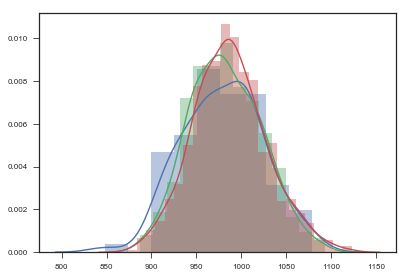

In [214]:
sns.distplot(t2_samples)
sns.distplot(t2_samples_500)
sns.distplot(t2_samples_1000)

In [215]:
print('100 samples {0:4.0f} +/- {1:4.1f}%'.format(np.mean(t2_samples), 200*np.std(t2_samples)/np.mean(t2_samples)))
print('500 samples {0:4.0f} +/- {1:4.1f}%'.format(np.mean(t2_samples_500), 200*np.std(t2_samples_500)/np.mean(t2_samples_500)))
print('1000 samples {0:4.0f} +/- {1:4.1f}%'.format(np.mean(t2_samples_1000), 200*np.std(t2_samples_1000)/np.mean(t2_samples_1000)))

100 samples  979 +/-  9.0%
500 samples  983 +/-  8.1%
1000 samples  987 +/-  8.3%


## Check difference in T matrix counting methods
These should all be the same for Brownian motion

In [216]:
count_methods = ['sliding', 'effective', 'sample']
for method in count_methods:
    model = BayesianMSM(lag=tau, nsamples=500, count_mode=method)
    model.fit(ctrajs)
    mean = model.sample_mean('timescales', k=1)
    std = model.sample_std('timescales', k=1)
    print('{2} : mean {0:4.2f} +/- {1:4.2f} %'.format(mean[0], 200*std[0]/mean[0], method))
    

sliding : mean 996.52 +/- 8.18 %
effective : mean 986.19 +/- 8.48 %
sample : mean 1253.30 +/- 41.14 %


## ML vs Bayesian Timescales

In [218]:
ml = MaximumLikelihoodMSM(lag=tau)
bayes = BayesianMSM(lag=tau, nsamples=500)
ml.fit(ctrajs)
bayes.fit(ctrajs)

BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=25, nsamples=500, nsteps=13, reversible=True,
      show_progress=True, sparse=False, statdist_constraint=None)

In [220]:
n_ts = 10
ml_ts = ml.timescales(k=n_ts)
bayes_ts = bayes.timescales(k=n_ts)

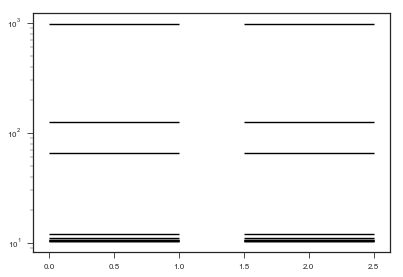

In [225]:
for i in range(n_ts):
    plt.hlines( ml_ts[i], 0,1)
    plt.hlines( bayes_ts[i], 1.5,2.5)
plt.yscale('log')

In [258]:
for i in range(n_ts):
    print('t {0:<#2}: ML {1:#6.2f} Bayes {2:#6.2f} Diff {3:#6.2f}%'.format(i+1, ml_ts[i], bayes_ts[i], 
                                                                          100*(ml_ts[i]/bayes_ts[i]-1)))

t 1 : ML 979.26 Bayes 978.14 Diff   0.11%
t 2 : ML 125.68 Bayes 125.69 Diff  -0.00%
t 3 : ML  66.23 Bayes  66.22 Diff   0.02%
t 4 : ML  12.10 Bayes  12.10 Diff  -0.03%
t 5 : ML  11.04 Bayes  11.05 Diff  -0.09%
t 6 : ML  10.64 Bayes  10.64 Diff  -0.02%
t 7 : ML  10.58 Bayes  10.58 Diff  -0.05%
t 8 : ML  10.46 Bayes  10.49 Diff  -0.23%
t 9 : ML  10.44 Bayes  10.45 Diff  -0.01%
t 10: ML  10.32 Bayes  10.36 Diff  -0.38%


## Make HMM

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/ipykernel/__main__.py:3: PyEMMA_DeprecationWarning: The dtrajs argument will be mandatory in the future for method hmm.
  app.launch_new_instance()


In [210]:
hmm

MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
           lag=25, maxit=1000, mincount_connectivity=0.25,
           msm_init=BayesianMSM(conf=0.95, connectivity='largest', count_mode='effective',
      dt_traj='1 step', lag=25, nsamples=100, nsteps=13, reversible=True,
      show_progress=True, sparse=False, statdist_constraint=None),
           nstates=4, observe_nonempty=True, reversible=True,
           separate=None, stationary=False, stride=1)